<a href="https://colab.research.google.com/github/bbboyb/Terratorch_Multicrop_Classification/blob/main/example_multitemporalcrop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MultiTemporalCrop Example

In [1]:
!pip install git+https://github.com/IBM/terratorch.git

  Cloning https://github.com/IBM/terratorch.git to /tmp/pip-req-build-jti4_nmf
  Running command git clone --filter=blob:none --quiet https://github.com/IBM/terratorch.git /tmp/pip-req-build-jti4_nmf
  Resolved https://github.com/IBM/terratorch.git to commit f7e655abd6cb71a8ccb515fe881d9053b393b337
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [1]:
import os
import sys
import numpy as np
import torch

import terratorch
from terratorch.datamodules import MultiTemporalCropClassificationDataModule
from terratorch.tasks import SemanticSegmentationTask
from terratorch.datasets.transforms import FlattenTemporalIntoChannels, UnflattenTemporalFromChannels

import albumentations
from albumentations import Compose, Flip
from albumentations.pytorch import ToTensorV2

import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint
import shutil

If you have the data already downloaded, update the `DATASET_PATH`. Otherwise, download it with the following code. Check [here](https://huggingface.co/datasets/ibm-nasa-geospatial/multi-temporal-crop-classification) for more details on this dataset.

In [2]:
DATASET_PATH = "./data"

In [5]:
from huggingface_hub import snapshot_download

repo_id = "ibm-nasa-geospatial/multi-temporal-crop-classification"
_ = snapshot_download(repo_id=repo_id, repo_type="dataset", cache_dir="./cache", local_dir=DATASET_PATH)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

validation_chips.tgz:   0%|          | 0.00/1.18G [00:00<?, ?B/s]

training_dst.png:   0%|          | 0.00/52.8k [00:00<?, ?B/s]

training_data.txt:   0%|          | 0.00/40.1k [00:00<?, ?B/s]

chips_df.csv:   0%|          | 0.00/362k [00:00<?, ?B/s]

training_chips.tgz:   0%|          | 0.00/10.6G [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/2.31k [00:00<?, ?B/s]

validation_data.txt:   0%|          | 0.00/10.0k [00:00<?, ?B/s]

validation_dst.png:   0%|          | 0.00/51.3k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.80k [00:00<?, ?B/s]

In [3]:
OUT_DIR = "./multicrop_example"  # where to save checkpoints and log files

BATCH_SIZE = 2
EPOCHS = 4
LR = 2.0e-4
WEIGHT_DECAY = 0.1
HEAD_DROPOUT=0.1
FREEZE_BACKBONE = False

BANDS = ["BLUE", "GREEN", "RED", "NIR_NARROW", "SWIR_1", "SWIR_2"]
NUM_FRAMES = 3

CLASS_WEIGHTS = [
    0, 1, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0
]

SEED = 0

#### Exploring the dataset

In [4]:
# Adding augmentations for a temporal dataset requires additional transforms
train_transforms = [
    terratorch.datasets.transforms.FlattenTemporalIntoChannels(),
    albumentations.Flip(),
    albumentations.pytorch.transforms.ToTensorV2(),
    terratorch.datasets.transforms.UnflattenTemporalFromChannels(n_timesteps=NUM_FRAMES),
]

In [11]:
shutil.unpack_archive("./data/training_chips.tgz","./data")
shutil.unpack_archive("./data/validation_chips.tgz","./data")

In [5]:
# This datamodule allows access to the dataset in its various splits.
data_module = MultiTemporalCropClassificationDataModule(
    data_root=DATASET_PATH,
    train_transform=train_transforms,
    expand_temporal_dimension=True,
)

In [6]:
# Checking the dataset means and stds
data_module.means, data_module.stds

([494.905781, 815.239594, 924.335066, 2968.881459, 2634.621962, 1739.579917],
 [284.925432, 357.84876, 575.566823, 896.601013, 951.900334, 921.407808])

In [7]:
# Checking train split size
data_module.setup("fit")
train_dataset = data_module.train_dataset
len(train_dataset)

3083

In [8]:
# Checking available bands
train_dataset.all_band_names

('BLUE', 'GREEN', 'RED', 'NIR_NARROW', 'SWIR_1', 'SWIR_2')

In [9]:
# Checking dataset classes
train_dataset.class_names

('Natural Vegetation',
 'Forest',
 'Corn',
 'Soybeans',
 'Wetlands',
 'Developed / Barren',
 'Open Water',
 'Winter Wheat',
 'Alfalfa',
 'Fallow / Idle Cropland',
 'Cotton',
 'Sorghum',
 'Other')

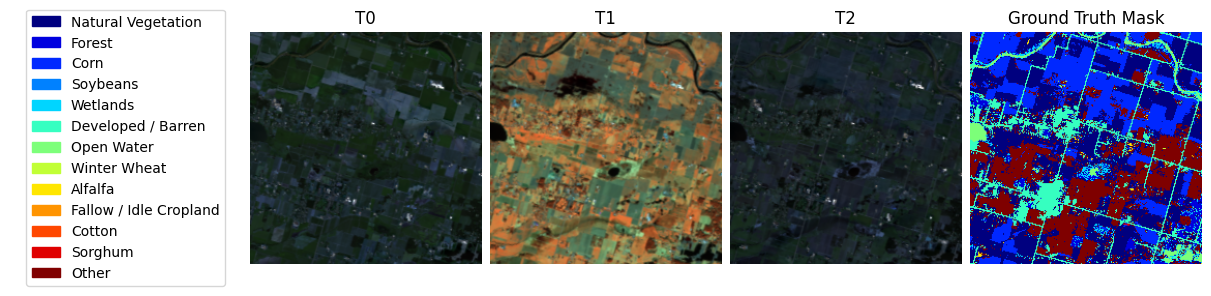

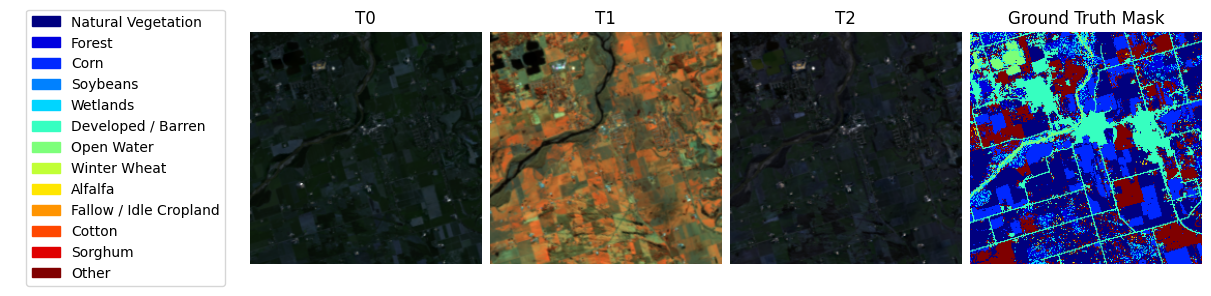

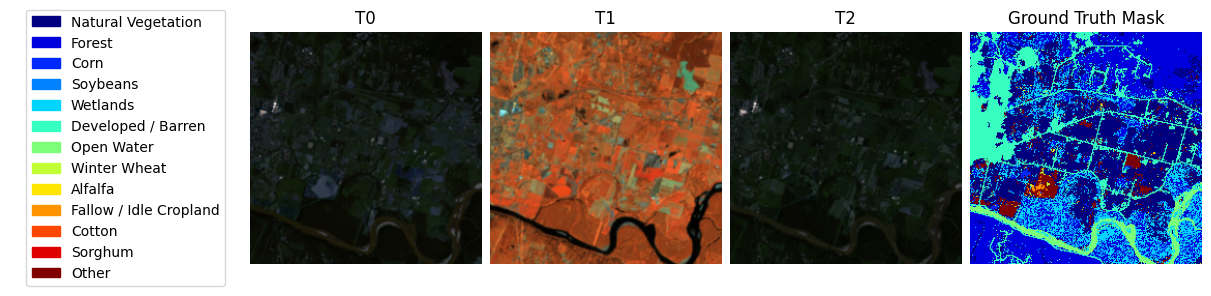

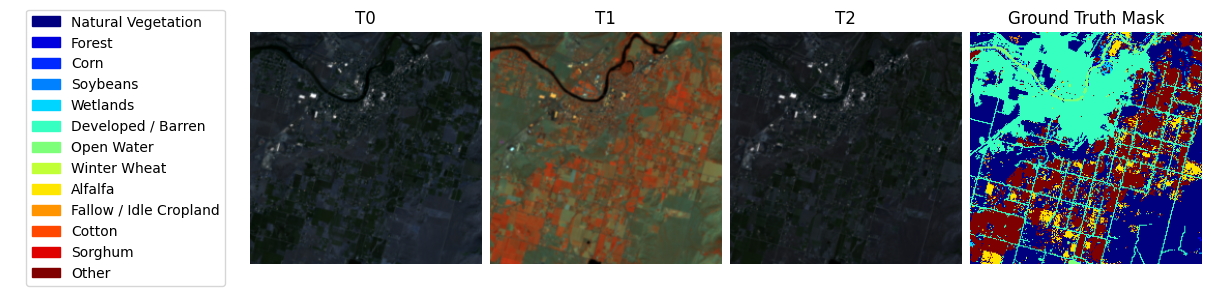

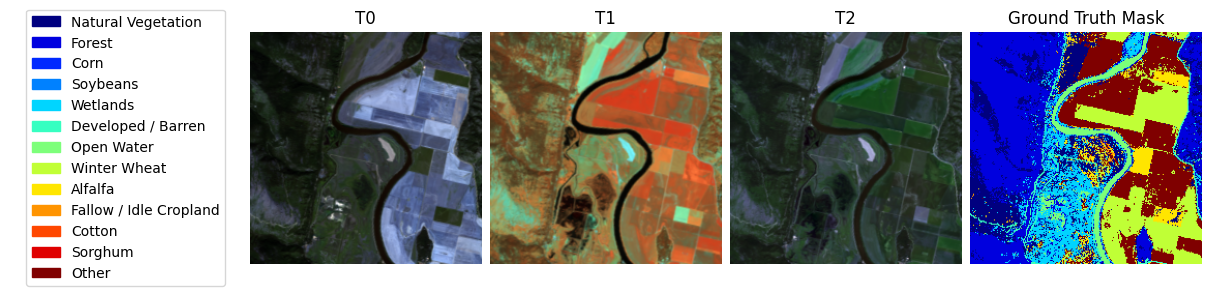

In [10]:
# Ploting a few samples
for i in range(5):
    train_dataset.plot(train_dataset[i])

In [11]:
# Checking validation split size
val_dataset = data_module.val_dataset
len(val_dataset)

771

In [12]:
# Checking test split
data_module.setup("test")
test_dataset = data_module.test_dataset
len(test_dataset)

771

#### Training setup

In [13]:
pl.seed_everything(SEED)

# Logger
logger = TensorBoardLogger(
    save_dir=OUT_DIR,
    name="multicrop_example",
)

# Callbacks
checkpoint_callback = ModelCheckpoint(
    monitor="val/Multiclass_Jaccard_Index",
    mode="max",
    dirpath=os.path.join(OUT_DIR, "multicrop_example", "checkpoints"),
    filename="best-checkpoint-{epoch:02d}-{val_loss:.2f}",
    save_top_k=1,
)

# Trainer
trainer = pl.Trainer(
    accelerator="auto",
    strategy="auto",
    devices="auto",
    precision="bf16-mixed",
    num_nodes=1,
    logger=logger,
    max_epochs=EPOCHS,
    check_val_every_n_epoch=1,
    log_every_n_steps=10,
    enable_checkpointing=True,
    callbacks=[checkpoint_callback],
    limit_predict_batches=1,  # predict only in the first batch for generating plots
)

# DataModule
data_module = MultiTemporalCropClassificationDataModule(
    batch_size=BATCH_SIZE,
    data_root=DATASET_PATH,
    train_transform=train_transforms,
    reduce_zero_label=True,
    expand_temporal_dimension=True,
    num_workers=2,
    use_metadata=True,
)


INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0
INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: `Trainer(limit_predict_batches=1)` was configured so 1 batch will be used.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer(limit_predict_batches=1)` was configured so 1 batch will be used.


In [14]:
# Model

backbone_args = dict(
    backbone_pretrained=True,
    backbone="prithvi_eo_v2_300_tl", # prithvi_eo_v2_300, prithvi_eo_v2_300_tl, prithvi_eo_v2_600, prithvi_eo_v2_600_tl
    backbone_coords_encoding=["time", "location"],
    backbone_bands=BANDS,
    backbone_num_frames=NUM_FRAMES,
)

decoder_args = dict(
    decoder="UperNetDecoder",
    decoder_channels=256,
    decoder_scale_modules=True,
)

necks = [
    dict(
            name="SelectIndices",
            # indices=[2, 5, 8, 11]    # indices for prithvi_vit_100
            indices=[5, 11, 17, 23],   # indices for prithvi_eo_v2_300
            # indices=[7, 15, 23, 31]  # indices for prithvi_eo_v2_600
        ),
    dict(
            name="ReshapeTokensToImage",
            effective_time_dim=NUM_FRAMES,
        )
    ]

model_args = dict(
    **backbone_args,
    **decoder_args,
    num_classes=len(CLASS_WEIGHTS),
    head_dropout=HEAD_DROPOUT,
    necks=necks,
    rescale=True,
)


model = SemanticSegmentationTask(
    model_args=model_args,
    plot_on_val=False,
    class_weights=CLASS_WEIGHTS,
    loss="ce",
    lr=LR,
    optimizer="AdamW",
    optimizer_hparams=dict(weight_decay=WEIGHT_DECAY),
    ignore_index=-1,
    freeze_backbone=FREEZE_BACKBONE,
    freeze_decoder=False,
    model_factory="EncoderDecoderFactory",
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/terratorch/models/decoders/upernet_decoder.py:37: UserWarning: DeprecationWarning: scale_modules is deprecated and will be removed in future versions. Use LearnedInterpolateToPyramidal neck instead.
  warnings.warn(


#### Training and testing the model

In [ ]:
# Training
trainer.fit(model, datamodule=data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | PixelWiseModel   | 364 M  | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | ModuleList       | 0      | train
-----------------------------------------------------------
364 M     Trainable params
0         Non-trainable params
364 M     Total params
1,457.832 Total estimated model params size (MB)
622       Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | PixelWiseModel   | 364 M  | train
1 | crite

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
ckpt_path = checkpoint_callback.best_model_path

# Test results
test_results = trainer.test(model, datamodule=data_module, ckpt_path=ckpt_path)

In [ ]:
test_results

[{'test/loss': 0.9476954936981201,
  'test/Multiclass_Accuracy': 0.6527066230773926,
  'test/multiclassaccuracy_0': 0.5258018374443054,
  'test/multiclassaccuracy_1': 0.7344022393226624,
  'test/multiclassaccuracy_2': 0.7455450296401978,
  'test/multiclassaccuracy_3': 0.6794723272323608,
  'test/multiclassaccuracy_4': 0.5796242356300354,
  'test/multiclassaccuracy_5': 0.6160429120063782,
  'test/multiclassaccuracy_6': 0.9140505790710449,
  'test/multiclassaccuracy_7': 0.7331819534301758,
  'test/multiclassaccuracy_8': 0.6815562844276428,
  'test/multiclassaccuracy_9': 0.6282399892807007,
  'test/multiclassaccuracy_10': 0.7162940502166748,
  'test/multiclassaccuracy_11': 0.7211771011352539,
  'test/multiclassaccuracy_12': 0.5427747368812561,
  'test/Multiclass_F1_Score': 0.6527066230773926,
  'test/Multiclass_Jaccard_Index': 0.47154152393341064,
  'test/multiclassjaccardindex_0': 0.4495747983455658,
  'test/multiclassjaccardindex_1': 0.5095115900039673,
  'test/multiclassjaccardindex_2'

#### Plot predictions

In [ ]:
# Now we can use the model to generate predictions and visualize results
# As we set limit_predict_batches=1, only the first batch will be used

preds = trainer.predict(model, datamodule=data_module, ckpt_path=ckpt_path)

In [ ]:
# Get first batch of samples for plotting

data_loader = trainer.predict_dataloaders
batch = next(iter(data_loader))

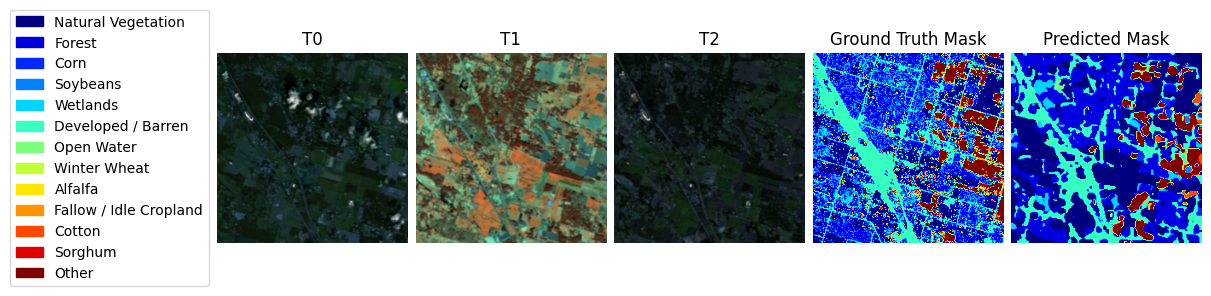

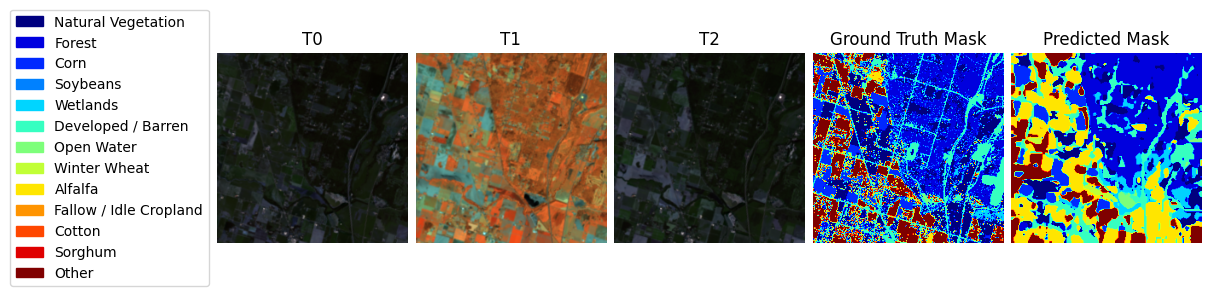

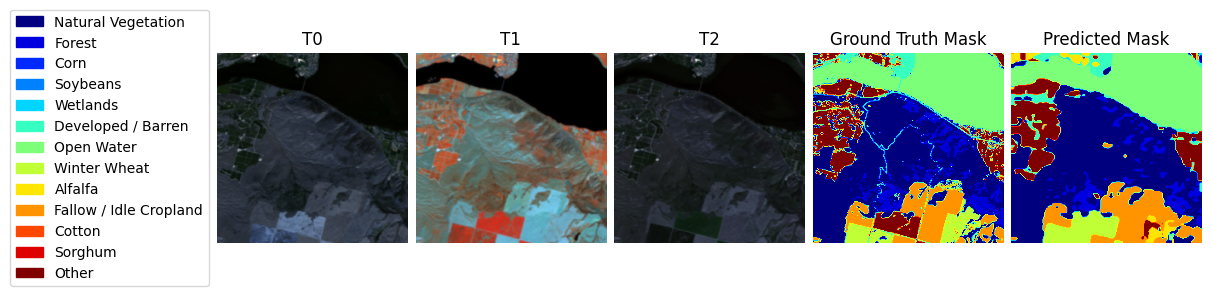

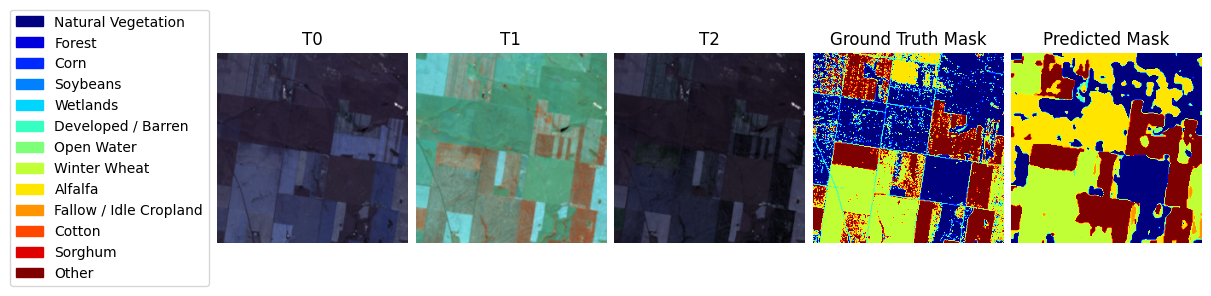

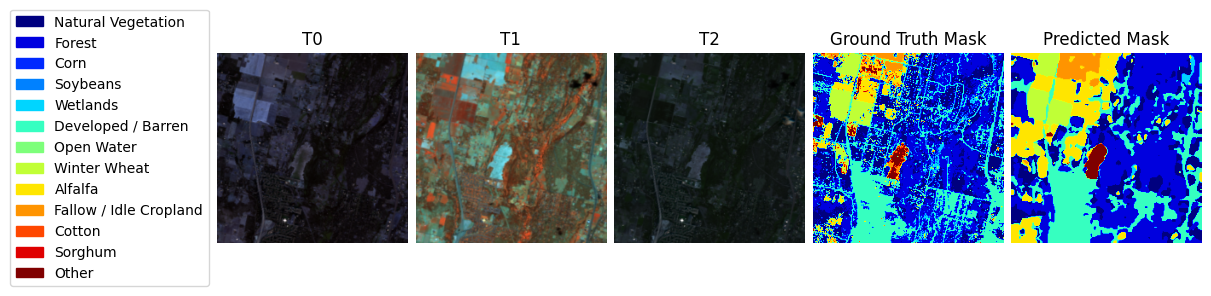

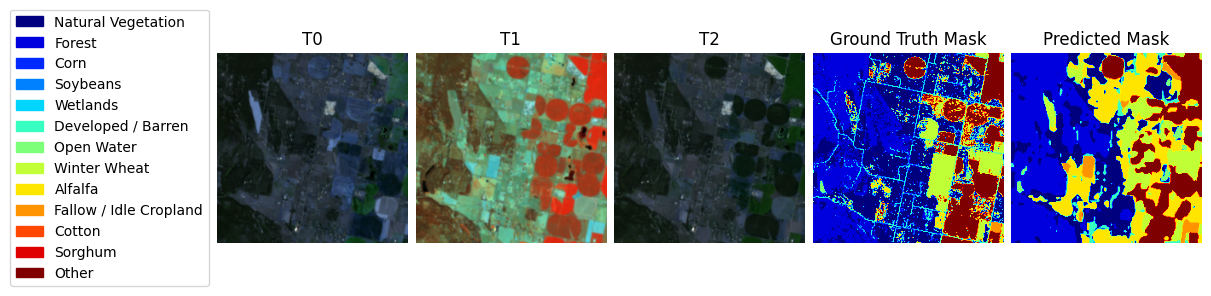

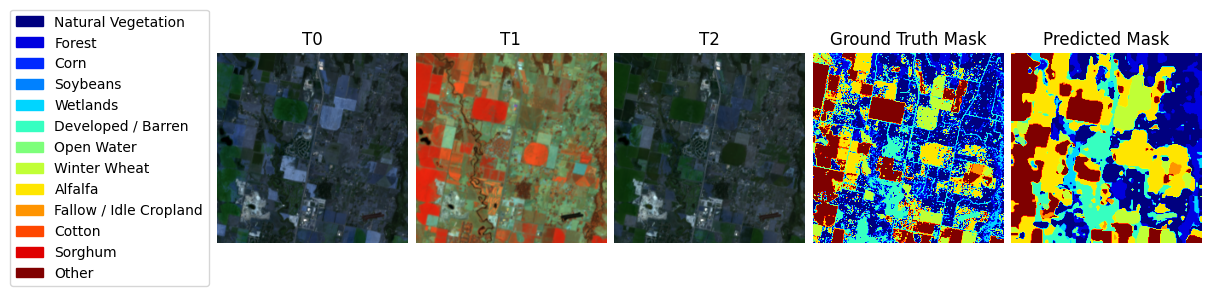

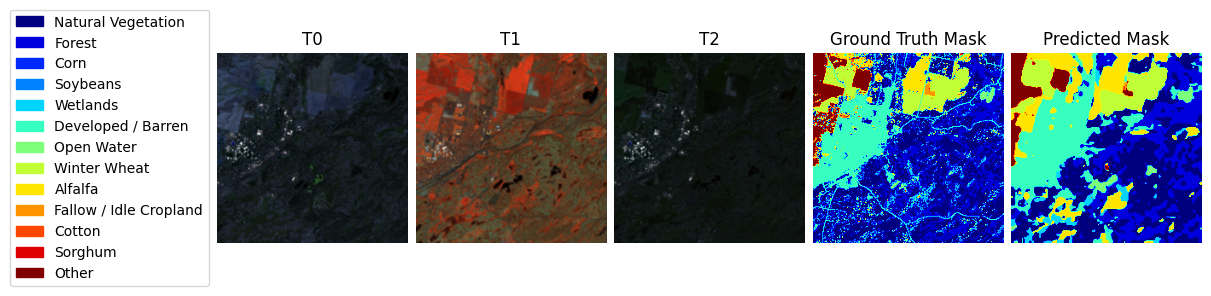

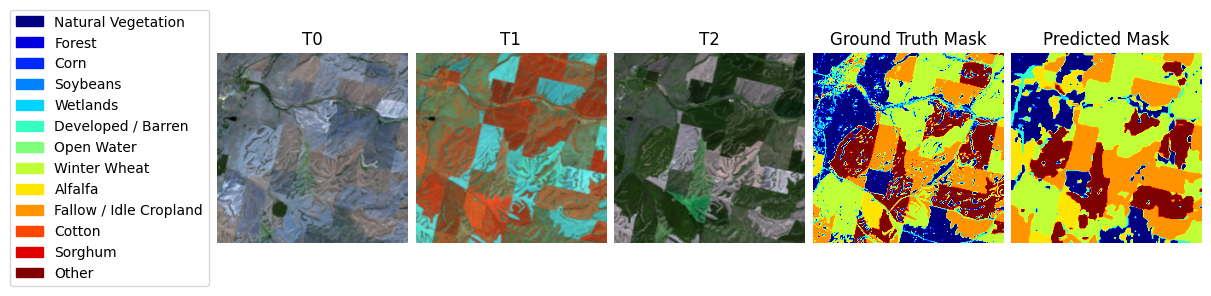

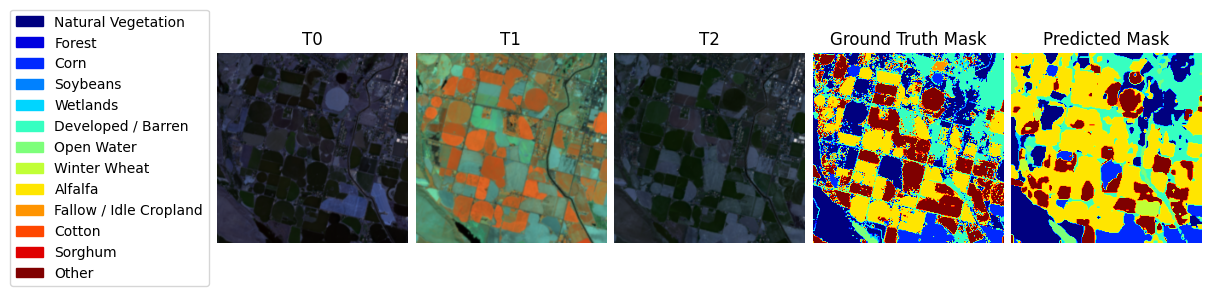

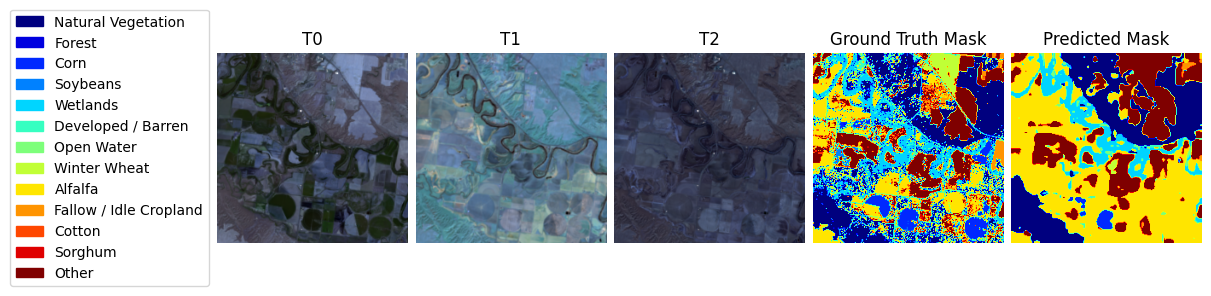

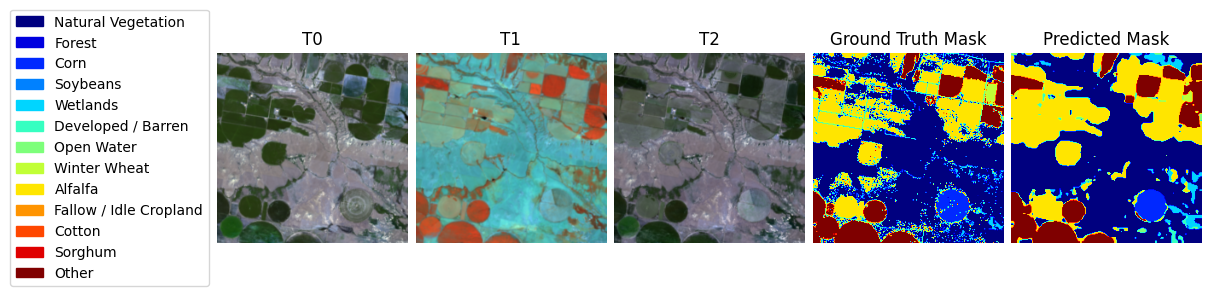

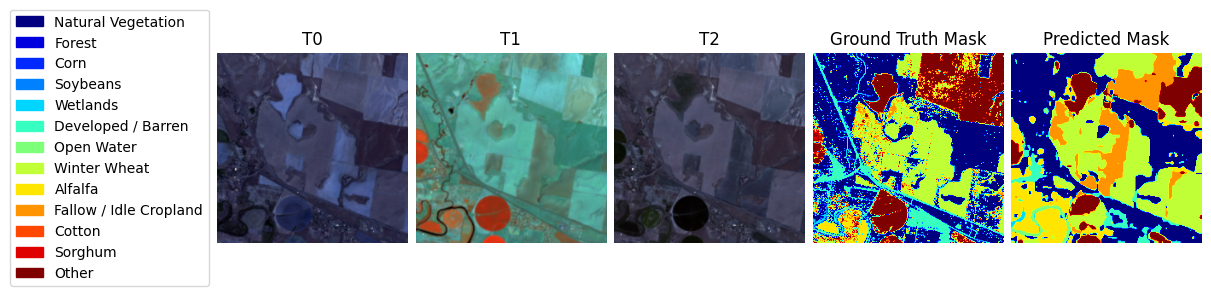

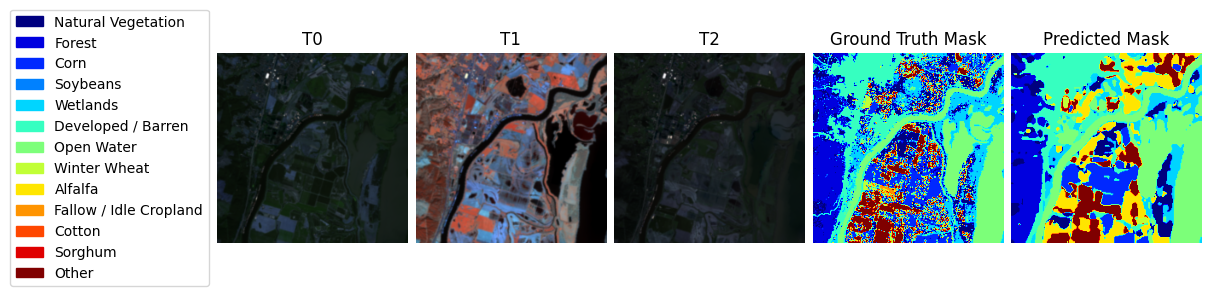

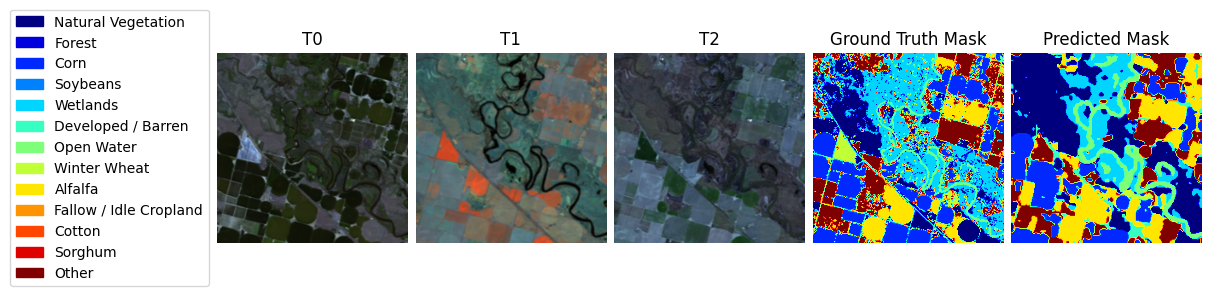

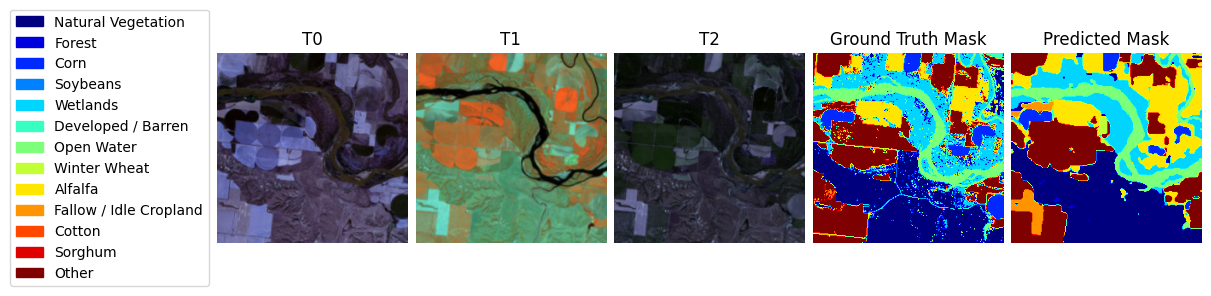

In [ ]:
# Plot samples and respective predictions

for i in range(BATCH_SIZE):

    sample = {key: batch[key][i] for key in batch}
    sample["prediction"] = preds[0][0][i].cpu().numpy()

    data_module.predict_dataset.plot(sample)